## Post Training Quantization with AIDGE

#### What is Network Quantization ?

Deploying large Neural Network architectures on embedded targets can be a difficult task as they often require billions of floating operations per inference.

To address this problem, several techniques have been developed over the past decades in order to reduce the computational load and energy consumption of those inferences. Those techniques include Pruning, Compression, Quantization and Distillation.

In particular, Post Training Quantization (PTQ) consists in taking an already trained network, and replacing the costly floating-point MADD by their integer counterparts. The use of Bytes instead of Floats also leads to a smaller memory bandwidth.

While this process can seem trivial, the naive approach consisting only in rounding the parameters and activations doesn't work in practice. Instead, we want to normalize the network in order to optimize the ranges of parameters and values propagated inside the network, before applying quantization.

#### The Quantization Pipeline

The PTQ algorithm consists in a 3 steps pipeline: 

- First we optimize the parameter ranges by propagating the scaling coefficients in the network. 
- Secondly, we compute the activation values over an input dataset, and insert the scaling nodes. 
- Finally, we quantize the network by reconfiguring the scaling nodes according to the desired precision.

![alt text](./static/ptq_diagram.png)


#### Doing the PTQ with AIDGE

This notebook shows how to perform PTQ of a Convolutional Network, trained on the MNIST dataset.

The tutorial is constructed as follows :

- Setup of the AIDGE environment
- Loading of the model and example inferences
- Evaluation of the trained model accuracy
- Post Training Quantization and test inferences
- Evaluation of the quantized model accuracy

As we will observe in this notebook, we get zero degradation of the accuracy for a 8-bits PTQ. 


Let's begin !

### (if needed) Download the model

If you don't have git-lfs, you can download the model and data using this piece of code

In [1]:
import os
import requests

def download_material(path: str) -> None:
    if not os.path.isfile(path):
        response = requests.get("https://gitlab.eclipse.org/eclipse/aidge/aidge/-/raw/dev/examples/tutorials/PTQ_tutorial/"+path+"?ref_type=heads")
        if response.status_code == 200:
            with open(path, 'wb') as f:
                f.write(response.content)
            print("File downloaded successfully.")
        else:
            print("Failed to download file. Status code:", response.status_code)

# Download onnx model file
download_material("ConvNet.onnx")
# Download data sample
download_material("mnist_samples.npy.gz")
# Download data label
download_material("mnist_labels.npy.gz")

File downloaded successfully.
File downloaded successfully.


File downloaded successfully.




#### Environment setup ...

We need numpy for manipulating the inputs, matplotlib for visualization purposes, and gzip to uncompress the numpy dataset.

Then we want to import the aidge modules :

- the core module contains everything we need to manipulate the graph.
- the backend module allows us to perform inferences using the CPU.
- the onnx module allows us to load the pretrained model (stored in an onnx file).
- the quantization module encaplsulate the Post Training Quantization algorithm.

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

import aidge_core
import aidge_onnx
import aidge_backend_cpu
import aidge_quantization

print(" Available backends : ", aidge_core.Tensor.get_available_backends())

 Available backends :  {'cpu'}


Then, let's define the configurations of this script ...

In [3]:
NB_SAMPLES  = 100
NB_BITS     = 8

Now, let's load and visualize some samples ...

In [4]:
samples = np.load(gzip.GzipFile('mnist_samples.npy.gz', "r"))
labels  = np.load(gzip.GzipFile('mnist_labels.npy.gz',  "r"))

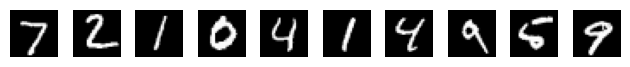

In [5]:
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(samples[i], cmap='gray')

#### Importing the model in AIDGE ...

In [6]:
aidge_model = aidge_onnx.load_onnx("ConvNet.onnx", verbose=False)
aidge_core.remove_flatten(aidge_model) # we want to get rid of the 'flatten' nodes ...

#### Setting up the AIDGE scheduler ...

In order to perform inferences with AIDGE we need to setup a scheduler. But before doing so, we need to create a data producer node and connect it to the network.

In [7]:
# Insert the input producer
input_node = aidge_core.Producer([1, 1, 28, 28], "XXX")
input_node.add_child(aidge_model)
aidge_model.add(input_node)

# Set up the backend
aidge_model.set_datatype(aidge_core.dtype.float32)
aidge_model.set_backend("cpu")

# Create the Scheduler
scheduler = aidge_core.SequentialScheduler(aidge_model)

#### Running some example inferences ...

Now that the scheduler is ready, let's perform some inferences. To do so we first declare a utility function that will prepare and set our inputs, propagate them and retreive the outputs.

In [8]:
def propagate(model, scheduler, sample):
    # Setup the input
    sample = np.reshape(sample, (1, 1, 28, 28))
    input_tensor = aidge_core.Tensor(sample)
    input_node.get_operator().set_output(0, input_tensor)
    # Run the inference
    scheduler.forward()
    # Gather the results
    output_node = model.get_output_nodes().pop()
    output_tensor = output_node.get_operator().get_output(0)
    return np.array(output_tensor)

print('\n EXAMPLE INFERENCES :')
for i in range(10):
    output_array = propagate(aidge_model, scheduler, samples[i])
    print(labels[i] , ' -> ', np.round(output_array, 2))


 EXAMPLE INFERENCES :
7  ->  [[-0.02  0.   -0.03  0.03  0.03  0.01 -0.    0.94  0.02 -0.03]]
2  ->  [[ 0.17  0.01  0.8  -0.03  0.01 -0.04  0.06 -0.01 -0.05  0.  ]]
1  ->  [[-0.    0.99  0.02  0.02 -0.02 -0.    0.03 -0.01  0.01 -0.04]]
0  ->  [[ 0.97  0.03 -0.02  0.01 -0.01  0.04  0.03  0.02  0.01 -0.07]]
4  ->  [[-0.05 -0.   -0.01 -0.02  1.13 -0.01 -0.01 -0.03  0.04 -0.01]]
1  ->  [[-0.01  1.06 -0.   -0.02 -0.01  0.02 -0.02  0.02  0.01 -0.01]]
4  ->  [[-0.03 -0.04  0.01 -0.01  0.94  0.01  0.04  0.03  0.19 -0.12]]
9  ->  [[-0.02  0.02  0.07  0.09  0.12 -0.02 -0.02 -0.02  0.12  0.67]]
5  ->  [[ 0.03 -0.03  0.04 -0.07  0.01  0.69  0.16  0.06  0.08 -0.02]]
9  ->  [[ 0.01 -0.01 -0.   -0.03  0.05 -0.02  0.01  0.06 -0.01  0.95]]


#### Computing the model accuracy ...

In [9]:
def compute_accuracy(model, samples, labels):
    acc = 0
    for i, x in enumerate(samples):
        y = propagate(model, scheduler, x)
        if labels[i] == np.argmax(y):
            acc += 1
    return acc / len(samples)

accuracy = compute_accuracy(aidge_model, samples[0:NB_SAMPLES], labels)
print(f'\n MODEL ACCURACY : {accuracy * 100:.3f}%')


 MODEL ACCURACY : 100.000%


#### Quantization dataset creation ...

We need to convert a subset of our Numpy samples into AIDGE tensors, so that they can be used to compute the activation ranges.

In [10]:
tensors = []
for sample in samples[0:NB_SAMPLES]:
    sample = np.reshape(sample, (1, 1, 28, 28))
    tensor = aidge_core.Tensor(sample)
    tensors.append(tensor)

#### Applying the PTQ to the model ...

Now that everything is ready, we can call the PTQ routine ! Note that after the quantization we need to update the scheduler.

In [11]:
aidge_quantization.quantize_network(aidge_model, NB_BITS, tensors)

scheduler = aidge_core.SequentialScheduler(aidge_model)

#### Running some quantized inferences ...

Now that our network is quantized, what about testing some inferences ? Let's do so, but before, we need not to forget that our 8-bit network expect 8-bit inputs ! We thus need to rescale the input tensors ...

In [12]:
scaling = 2**(NB_BITS-1)-1
for i in range(NB_SAMPLES):
    samples[i] = np.round(samples[i] * scaling)

We can now perform our quantized inferences ...

In [13]:
print('\n EXAMPLE QUANTIZED INFERENCES :')
for i in range(10):
    input_array = np.reshape(samples[i], (1, 1, 28, 28))
    output_array = propagate(aidge_model, scheduler, input_array)
    print(labels[i] , ' -> ', np.round(output_array, 2))


 EXAMPLE QUANTIZED INFERENCES :
7  ->  [[ -1.86   0.5   -3.07   3.28   2.93   1.1   -0.12 103.51   1.85  -2.92]]
2  ->  [[ 1.872e+01  1.250e+00  8.744e+01 -3.360e+00  6.600e-01 -4.480e+00
   6.280e+00 -1.130e+00 -6.000e+00  6.000e-02]]
1  ->  [[ -0.15 109.     2.27   1.93  -1.75  -0.39   3.53  -1.16   1.36  -4.48]]
0  ->  [[106.18   3.42  -2.7    0.72  -0.62   4.9    2.75   1.91   0.92  -7.82]]
4  ->  [[-5.7100e+00 -9.0000e-02 -9.7000e-01 -1.9100e+00  1.2401e+02 -9.6000e-01
  -1.3900e+00 -2.9600e+00  4.3000e+00 -1.0500e+00]]
1  ->  [[ -0.57 116.28  -0.4   -2.17  -1.38   1.62  -2.5    1.66   1.49  -1.27]]
4  ->  [[ -3.32  -4.14   0.61  -1.43 102.52   1.56   4.78   3.59  20.92 -12.72]]
9  ->  [[-2.31  2.32  7.17  9.86 12.81 -2.33 -2.67 -1.89 13.38 73.47]]
5  ->  [[ 3.16 -3.83  4.07 -8.06  1.2  76.01 18.02  6.82  8.64 -2.14]]
9  ->  [[ 1.2800e+00 -6.7000e-01 -8.0000e-02 -3.4100e+00  4.9700e+00 -1.7700e+00
   1.4800e+00  6.6500e+00 -1.4700e+00  1.0455e+02]]


### Computing the quantized accuracy ...

Just as we've done for the initial network, we can compute the quantized model accuracy ...

In [14]:
accuracy = compute_accuracy(aidge_model, samples[0:NB_SAMPLES], labels)
print(f'\n QUANTIZED MODEL ACCURACY : {accuracy * 100:.3f}%')


 QUANTIZED MODEL ACCURACY : 100.000%


#### Work is done !

We see that a 8-bit PTQ does not affect the accuracy of our model ! This result shows that a proper quantization algorithm can be used to deploy a Neural Network on very small devices, where manipulating bytes is optimal. We encourage you to run this notebook again with even more aggressive quantization values !

In [15]:
print('That\'s all folks !')

That's all folks !
